In [1]:
from u_net import UNet
from utils.config import Config
from torch.utils.data import DataLoader 
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.autograd import Variable
from utils import train, predict
from utils import NaiveDataset, splitIndices
from utils.constants import NUM_CLASSES, TRAIN_DATA_PATH, TRAIN_LABELS_PATH, NUM_TRAIN, TEST_DATA_PATH, TEST_LABELS_PATH, LABEL_MAP, LABEL_LIST
from utils import visualize
from utils.layers import Flatten
import copy
import pandas as pd
from utils.train import check_per_class_accuracy
from sklearn.preprocessing import MultiLabelBinarizer
import torch
from torch import nn

import timeit

from scipy.optimize import nnls

from IPython.display import Image, display

import numpy as np

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
class Args:
    pass
args = Args()

In [3]:
train_dataset = NaiveDataset(TRAIN_DATA_PATH, TRAIN_LABELS_PATH)

np.set_printoptions(threshold=np.inf)
M_cpu = train_dataset.labels_tensor.cpu().numpy()
w_vec, res = np.linalg.lstsq(M_cpu.T,np.ones((17,)))[0:2]
print(max(w_vec),min(w_vec))
print(np.sum(w_vec),w_vec.shape)

40479
0.0151350798988 -0.000422307913681
3.99992225721 (40479,)


Config for experiment:   upsampled_unet_overfit_0602_06.00.07
	title: upsampled_unet_overfit
	gpu: True
	epochs: 1
	batch_size: 10
	learning_rate: 0.001
	num_train (if None using all): 100
	num_val (if None using all): 10

	save_dest: ./experiments/upsampled_unet_overfit_0602_06.00.07
	save_every: 25
	print_every: 5
	eval_every: None

Number of model parameters: 8647442


Starting epoch 1 / 1
t = 5, loss = 6.2494
t = 10, loss = 1.4975
Finished Epoch 1/1
Evaluating...
F2 score {train} : Got 24.35
Global recall {train} : Got 757 / 1700 correct (44.53)
All or none acc {train} : Got 0 / 100 correct (0.00)
F2 score {val} : Got 31.61
Global recall {val} : Got 79 / 170 correct (46.47)
All or none acc {val} : Got 0 / 10 correct (0.00)

Finished training.
Config for experiment:   upsampled_unet_overfit_0602_06.00.57
	title: upsampled_unet_overfit
	gpu: True
	epochs: 1
	batch_size: 10
	learning_rate: 0.001
	num_train (if None using all): 100
	num_val (if None using all): 10

	save_dest: ./experi

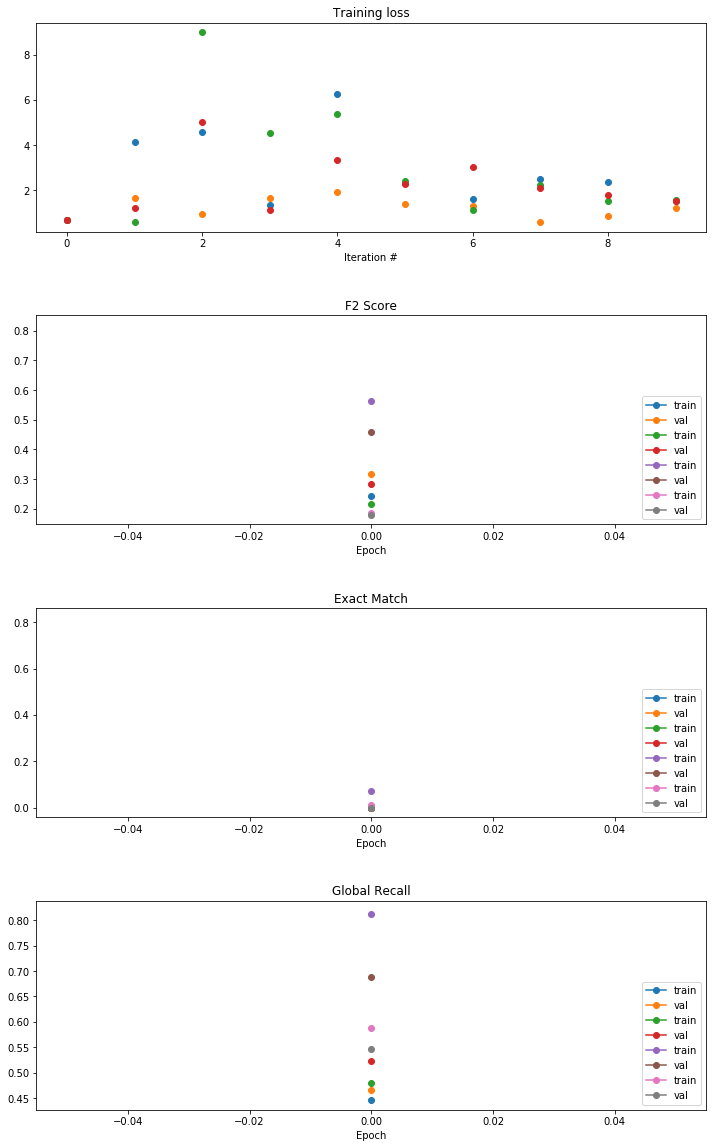

In [14]:
%%timeit
args.test = False
args.bs = 10
args.e = 1
args.nt = 100
args.nv = 10
args.lr = 1e-3
args.gpu = True
args.pe = 5
args.ee = None
args.seed = 231
args.title = "upsampled_unet_overfit"
args.path = "./experiments"
args.checkpoint = ""
args.predict = False
args.save_every = 25
args.no_save = False

# Get Config
config = Config(args)
config.log(config)

train_idx, val_idx = splitIndices(train_dataset, config, shuffle = False)

eps = 1.
train_sampler = WeightedRandomSampler(weights = w_vec[train_idx]+min(w_vec[train_idx])+eps, num_samples=config.num_train, replacement=False) #THIS IS DIFFERENT
val_sampler = WeightedRandomSampler(weights = w_vec[val_idx]+min(w_vec[val_idx])+eps, num_samples=config.num_val, replacement=False) #THIS IS DIFFERENT.

train_loader = DataLoader(train_dataset, batch_size = config.batch_size, num_workers = 8, sampler = train_sampler)
val_loader = DataLoader(train_dataset, batch_size = config.batch_size, num_workers = 8, sampler = val_sampler)

config.train_loader = train_loader
config.val_loader = val_loader

#create loss function
loss_fn = nn.MultiLabelSoftMarginLoss().type(config.dtype)

# Create Model
model = UNet()
if config.use_gpu:
    model = model.cuda() #is this the correct way to do it?

# Train and Eval Model
results = train(model, config, loss_fn=loss_fn)
visualize.plot_results(results, config)
torch.cuda.synchronize() # Make sure there are no pending GPU computations

In [15]:
args.test = False
args.bs = 10
args.e = 100
args.nt = 100
args.nv = 10
args.lr = 1e-3
args.gpu = True
args.pe = 5
args.ee = None
args.seed = 231
args.title = "upsampled_unet_overfit"
args.path = "./experiments"
args.checkpoint = ""
args.predict = False
args.save_every = 25
args.no_save = False

# Get Config
config = Config(args)
config.log(config)

train_idx, val_idx = splitIndices(train_dataset, config, shuffle = False)

eps = 1.
train_sampler = WeightedRandomSampler(weights = w_vec[train_idx]+min(w_vec[train_idx])+eps, num_samples=config.num_train, replacement=False) #THIS IS DIFFERENT
val_sampler = WeightedRandomSampler(weights = w_vec[val_idx]+min(w_vec[val_idx])+eps, num_samples=config.num_val, replacement=False) #THIS IS DIFFERENT.

train_loader = DataLoader(train_dataset, batch_size = config.batch_size, num_workers = 8, sampler = train_sampler)
val_loader = DataLoader(train_dataset, batch_size = config.batch_size, num_workers = 8, sampler = val_sampler)

config.train_loader = train_loader
config.val_loader = val_loader

#create loss function
loss_fn = nn.MultiLabelSoftMarginLoss().type(config.dtype)

# Create Model
model = UNet()
if config.use_gpu:
    model = model.cuda() #is this the correct way to do it?

# Train and Eval Model
results = train(model, config, loss_fn=loss_fn)
visualize.plot_results(results, config)

Config for experiment:   upsampled_unet_overfit_0602_06.04.34
	title: upsampled_unet_overfit
	gpu: True
	epochs: 100
	batch_size: 10
	learning_rate: 0.001
	num_train (if None using all): 100
	num_val (if None using all): 10

	save_dest: ./experiments/upsampled_unet_overfit_0602_06.04.34
	save_every: 25
	print_every: 5
	eval_every: None

Number of model parameters: 8647442


Starting epoch 1 / 100
t = 5, loss = 2.3000
t = 10, loss = 3.0864
Finished Epoch 1/100
Evaluating...
F2 score {train} : Got 25.71
Global recall {train} : Got 1195 / 1700 correct (70.29)
All or none acc {train} : Got 0 / 100 correct (0.00)
F2 score {val} : Got 29.65
Global recall {val} : Got 118 / 170 correct (69.41)
All or none acc {val} : Got 0 / 10 correct (0.00)

Starting epoch 2 / 100
t = 5, loss = 1.3817
t = 10, loss = 1.1945
Finished Epoch 2/100
Evaluating...
F2 score {train} : Got 17.70
Global recall {train} : Got 873 / 1700 correct (51.35)
All or none acc {train} : Got 0 / 100 correct (0.00)
F2 score {val} :

/home/cs231n/myVE35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


F2 score {val} : Got 70.97
Global recall {val} : Got 152 / 170 correct (89.41)
All or none acc {val} : Got 3 / 10 correct (30.00)

Starting epoch 10 / 100
t = 5, loss = 0.2741
t = 10, loss = 0.1942
Finished Epoch 10/100
Evaluating...
F2 score {train} : Got 75.90
Global recall {train} : Got 1561 / 1700 correct (91.82)
All or none acc {train} : Got 33 / 100 correct (33.00)
F2 score {val} : Got 81.59
Global recall {val} : Got 154 / 170 correct (90.59)
All or none acc {val} : Got 3 / 10 correct (30.00)

Starting epoch 11 / 100
t = 5, loss = 0.1066
t = 10, loss = 0.3215
Finished Epoch 11/100
Evaluating...
F2 score {train} : Got 76.53
Global recall {train} : Got 1569 / 1700 correct (92.29)
All or none acc {train} : Got 37 / 100 correct (37.00)
F2 score {val} : Got 77.27
Global recall {val} : Got 154 / 170 correct (90.59)
All or none acc {val} : Got 3 / 10 correct (30.00)

Starting epoch 12 / 100
t = 5, loss = 0.1086
t = 10, loss = 0.2925
Finished Epoch 12/100
Evaluating...
F2 score {train} :

Process Process-1066:
Process Process-1067:
Process Process-1068:
Process Process-1070:
Process Process-1071:
Process Process-1069:
Process Process-1065:
Process Process-1072:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in 

KeyboardInterrupt: 

In [ ]:
args.test = False
args.bs = 10
args.e = 3 #3 b/c about to run out of gpu credits again, and want to finish the run
args.nt = 32000
args.nv = 8000
args.lr = 1e-3
args.gpu = True
args.pe = 100
args.ee = None
args.seed = 231
args.title = "upsampled_unet_full"
args.path = "./experiments"
args.checkpoint = ""
args.predict = False
args.save_every = 1
args.no_save = False

# Get Config
config = Config(args)
config.log(config)

train_idx, val_idx = splitIndices(train_dataset, config, shuffle = True)

eps = 1. #this is a dumb idea..since weights will be centered around 1 and their relative importance is biased
train_sampler = WeightedRandomSampler(weights = w_vec[train_idx]+min(w_vec[train_idx])+eps, num_samples=config.num_train, replacement=False) #THIS IS DIFFERENT
val_sampler = WeightedRandomSampler(weights = w_vec[val_idx]+min(w_vec[val_idx])+eps, num_samples=config.num_val, replacement=False) #THIS IS DIFFERENT.

train_loader = DataLoader(train_dataset, batch_size = config.batch_size, num_workers = 8, sampler = train_sampler)
val_loader = DataLoader(train_dataset, batch_size = config.batch_size, num_workers = 8, sampler = val_sampler)

config.train_loader = train_loader
config.val_loader = val_loader

#create loss function
loss_fn = nn.MultiLabelSoftMarginLoss().type(config.dtype)

# Create Model
model = UNet()
if config.use_gpu:
    model = model.cuda() #is this the correct way to do it?

# Train and Eval Model
results = train(model, config, loss_fn=loss_fn)
visualize.plot_results(results, config)

Config for experiment:   upsampled_unet_full_0602_06.54.15
	title: upsampled_unet_full
	gpu: True
	epochs: 3
	batch_size: 10
	learning_rate: 0.001
	num_train (if None using all): 32000
	num_val (if None using all): 8000

	save_dest: ./experiments/upsampled_unet_full_0602_06.54.15
	save_every: 1
	print_every: 100
	eval_every: None

Number of model parameters: 8647442


Starting epoch 1 / 3
t = 100, loss = 0.1901
t = 200, loss = 0.3119
t = 300, loss = 0.2715
t = 400, loss = 0.3401
t = 500, loss = 0.3801
t = 600, loss = 0.2216
t = 700, loss = 0.6561
t = 800, loss = 0.2869
t = 900, loss = 0.2980

TBD - change the upsampling so we get rid of eps entirely, and instead start from 2*min so they're all positive and offset by 0 by 2*min

In [ ]:
# Evaluate Results
test_dataset = NaiveDataset(TEST_DATA_PATH, TEST_LABELS_PATH, num_examples = 20)
test_loader = DataLoader(test_dataset, batch_size = 10, shuffle = False, num_workers = 3)

make_predictions = False
if make_predictions:
    predict(model, config, test_loader, dataset = "test")
    predict(model, config, train_loader, dataset = "train")
    predict(model, config, val_loader, dataset = "val")